# Steem Analytics

Here is some code to compute and visualise the following things regarding Steem (using [beem 0.21.1](https://pypi.org/project/beem/0.21.1/)):
* Curation Rewards per Month
* Curation Rewards for following Trails
* Income from Delegations (transfers)
* Steem Raking on CoinMarketCap

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import requests
import time
from datetime import datetime, timedelta
from collections import defaultdict

from bs4 import BeautifulSoup
from beem.account import Account
from beem import Steem
from beem.amount import Amount

**Note**: If you want to do those computations for yourself, just change the constant ``USER``:

In [2]:
USER = 'cpufronz'
STM = Steem('https://api.steemit.com')
ACC = Account(USER, steem_instance=STM)
DAYS = (datetime.now() - datetime(2016, 3, 24)).days # days since the inital release of Steem

### Some helper functions:

In [3]:
def account_votes():
    votes = ACC.get_account_votes()
    return votes

def curation_rewards():
    rewards = []
    stop = datetime.utcnow() - timedelta(days=DAYS)
    reward_vests = Amount("0 VESTS")
    for reward in ACC.history_reverse(stop=stop, only_ops=["curation_reward"]):
        reward_vests += Amount(reward['reward'])
        rewards.append(reward)
    curation_rewards_SP = ACC.steem.vests_to_sp(reward_vests.amount)
#    print("Rewards are %.3f SP" % curation_rewards_SP)
    return rewards

def transfers():
    stop = datetime.utcnow() - timedelta(days=DAYS)
    senders = defaultdict(int)
    senders_amount_steem = defaultdict(float)
    senders_amount_sbd = defaultdict(float)

    for transfer in ACC.history_reverse(stop=stop, only_ops=['transfer']):
        # not including transfers to myself
        if transfer['from'] == USER:
            continue
        
        senders[transfer['from']] += 1
        amount = float(transfer['amount']['amount'])/(10**int(transfer['amount']['precision']))

        if transfer['amount']['nai'] == "@@000000021":
            senders_amount_steem[transfer['from']] += amount
        elif transfer['amount']['nai'] == "@@000000013":
            senders_amount_sbd[transfer['from']] += amount
    return senders_amount_steem, senders_amount_sbd, senders

### Upvotes per Month and Curation Rewards:

2017-11:   39 upvotes, 0.000 STEEM curation reward
2017-12:  328 upvotes, 0.086 STEEM curation reward
2018-01:  330 upvotes, 0.084 STEEM curation reward
2018-02:  207 upvotes, 0.160 STEEM curation reward
2018-03:  368 upvotes, 0.245 STEEM curation reward
2018-04:  267 upvotes, 0.220 STEEM curation reward
2018-05:  283 upvotes, 0.262 STEEM curation reward
2018-06:  235 upvotes, 0.186 STEEM curation reward
2018-07:  191 upvotes, 0.074 STEEM curation reward
2018-08:  200 upvotes, 0.161 STEEM curation reward
2018-09:  221 upvotes, 0.287 STEEM curation reward
2018-10:  208 upvotes, 0.359 STEEM curation reward
2018-11:  212 upvotes, 0.218 STEEM curation reward
2018-12:  354 upvotes, 0.447 STEEM curation reward
2019-01:  375 upvotes, 0.472 STEEM curation reward
2019-02:  210 upvotes, 0.218 STEEM curation reward
2019-03:  353 upvotes, 0.276 STEEM curation reward
2019-04: 1007 upvotes, 0.176 STEEM curation reward
2019-05: 1350 upvotes, 0.071 STEEM curation reward
2019-06:  919 upvotes, 0.020 ST

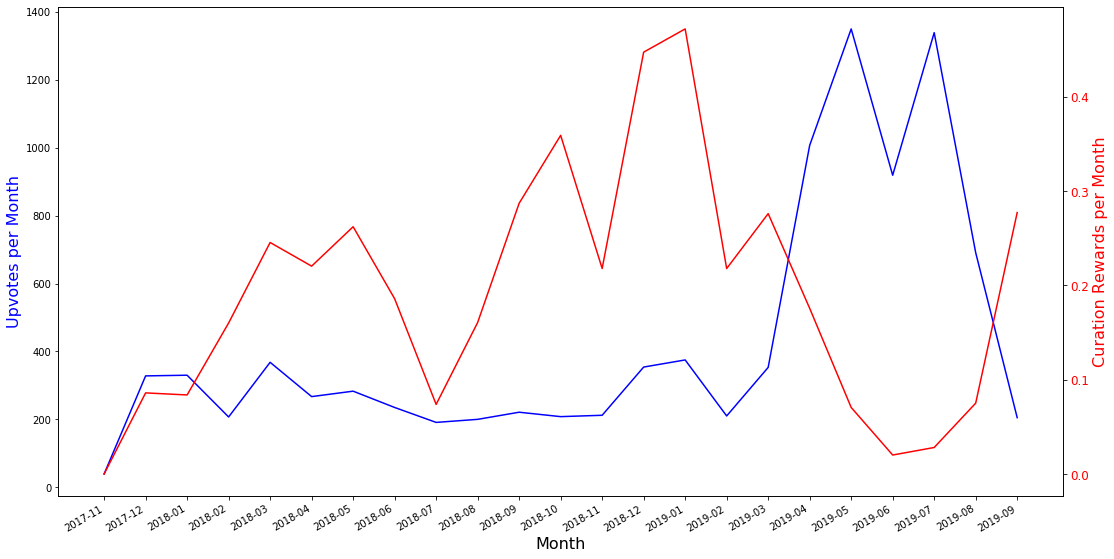

In [4]:
rewards = curation_rewards()
votes = account_votes()


rewards_per_month = defaultdict(float)
rewards_per_month['2017-11'] = 0 # in November 2017 I didn't get any curation rewards
for r in rewards:
    key = r['timestamp'][:7]
    rewards_per_month[key] += ACC.steem.vests_to_sp(Amount(r['reward']))
    
upvotes_per_month = defaultdict(int)
for v in votes:
    key = v['last_update'][:7]
    upvotes_per_month[key] += 1

upvotes_per_month_sorted = sorted(upvotes_per_month.items(), key=lambda k_v: k_v[0])
rewards_per_month_sorted = sorted(rewards_per_month.items(), key=lambda k_v: k_v[0])

fig, ax1 = plt.subplots(figsize=(18, 10))
fig.autofmt_xdate()
ax1_color = 'blue'
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Upvotes per Month', color=ax1_color, fontsize=16)
ax1.plot([t[0] for t in upvotes_per_month_sorted], [v[1] for v in upvotes_per_month_sorted], color=ax1_color)

ax2 = ax1.twinx()
ax2_color = 'red'
ax2.set_ylabel('Curation Rewards per Month', color=ax2_color, fontsize=16)
ax2.plot([t[0] for t in rewards_per_month_sorted], [r[1] for r in rewards_per_month_sorted], color=ax2_color)
ax2.tick_params(axis='y', labelcolor=ax2_color, labelsize='large')
fig.savefig('upvotes_rewards.png')

for i, _ in enumerate(upvotes_per_month_sorted):
    month = upvotes_per_month_sorted[i][0]
    upvotes = upvotes_per_month_sorted[i][1]
    cur_reward = rewards_per_month_sorted[i][1]
    print('{0:s}: {1:4d} upvotes, {2:5.3f} STEEM curation reward'.format(month, upvotes, cur_reward))
print('Total Curation Rewards: {:5.3f} STEEM'.format(sum([i[1] for i in rewards_per_month_sorted])))

### Curation Rewards for the Trails, I'm following:
**Note:** I set steemvoter.com to upvote everything utopian.trail upvotes with 50% and I also joined the NextColony guild, where I upvote everything with 25%, so I use the percentages to indetify for which trail I voted. So if you also followed those trails, this part of the code will only work for you, if you did the same thing.

In [5]:
utopian = {}
next_colony = {}
for v in votes:
    authorperm = v['author'] + '/' + v['permlink']
    if v['vote_percent'] == 5000:
        utopian[authorperm] = v
    if v['vote_percent'] == 2500:
        next_colony[authorperm] = v

utopian_rewards = 0
next_colony_rewards = 0
for r in rewards:
    authorperm = r['comment_author'] + '/' + r['comment_permlink']
    curation_reward_sp = ACC.steem.vests_to_sp(Amount(r['reward']))
    if authorperm in utopian:
        utopian_rewards += curation_reward_sp
        #print('Reward for Utopian Upvote: {0:.3f} {1:.75} '.format(curation_reward_sp, authorperm))
    elif authorperm in next_colony:
        next_colony_rewards += curation_reward_sp
        #print('Reward for NextColony Upvote: {0:.3f} {1:.75} '.format(curation_reward_sp, authorperm))

print('Curation Rewards from following Utopian:     {:5.3f}'.format(utopian_rewards))
print('Curation Rewards from following Next Colony: {:5.3f}'.format(next_colony_rewards))

Curation Rewards from following Utopian:     0.150
Curation Rewards from following Next Colony: 0.003


### Rewards from Transfers (aka Delegations):
I started delegating to the following accounts on 2019-03-27:
* ocdb (50.530 SP)
* steem-ua (25.265 SP)
* steemstem (25.265 SP)
* trufflepig (25.265 SP)

About steem-ua: You don't get rewards as transfers, but in the form of upvotes. Since writing a function to evaluate the value of SteemUA upvotes is quite tedious, I'm just putting those values here manually, the multiplications are there to include the curation and beneficiaries (e.g. when using Steepshot or eSteem surfer). Those values are in dollars, I got them from [steemd.com](http://steemd.com/). For the calculations, I will assume that 1 SBD = $1, which is not necessarily the case (looking it up on [CoinMarketCap](https://coinmarketcap.com/currencies/steem-dollars/) or [Coingecko](https://www.coingecko.com/en/coins/steem-dollars?utm_content=steem-dollars&utm_medium=search_coin&utm_source=coingecko) shows, that this is actually rarly the case: the actual values should be lower.

**Note**: I set the threshold to be included in this plot and calculation to be 0.01 Steem or SDB, in order to exclude "spam".

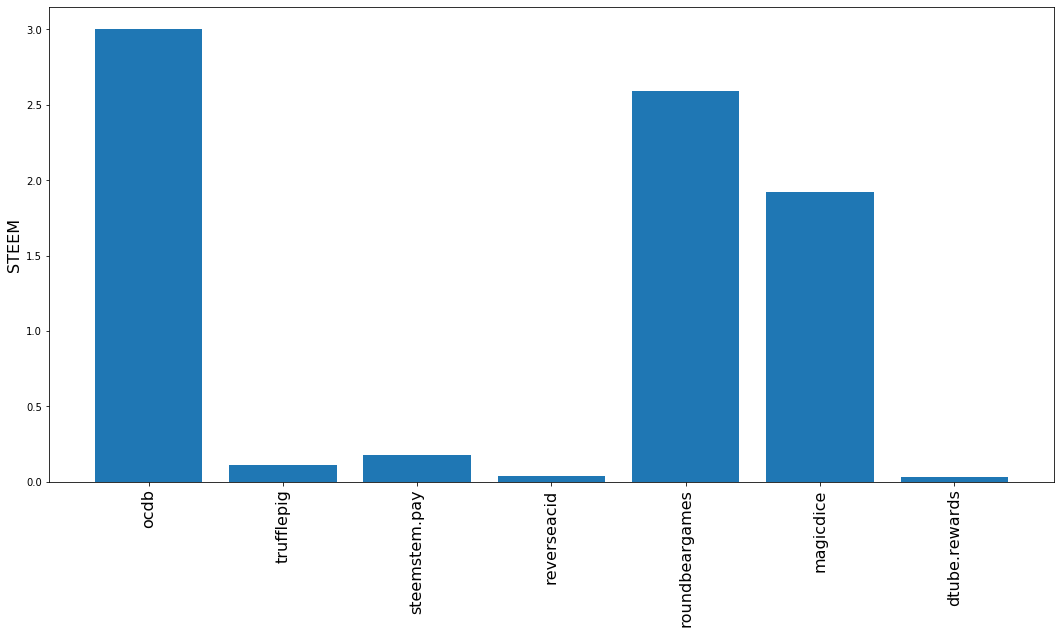

ocdb          : 2.999
trufflepig    : 0.111
steemstem.pay : 0.177
reverseacid   : 0.038
roundbeargames: 2.590
magicdice     : 1.921
dtube.rewards : 0.033


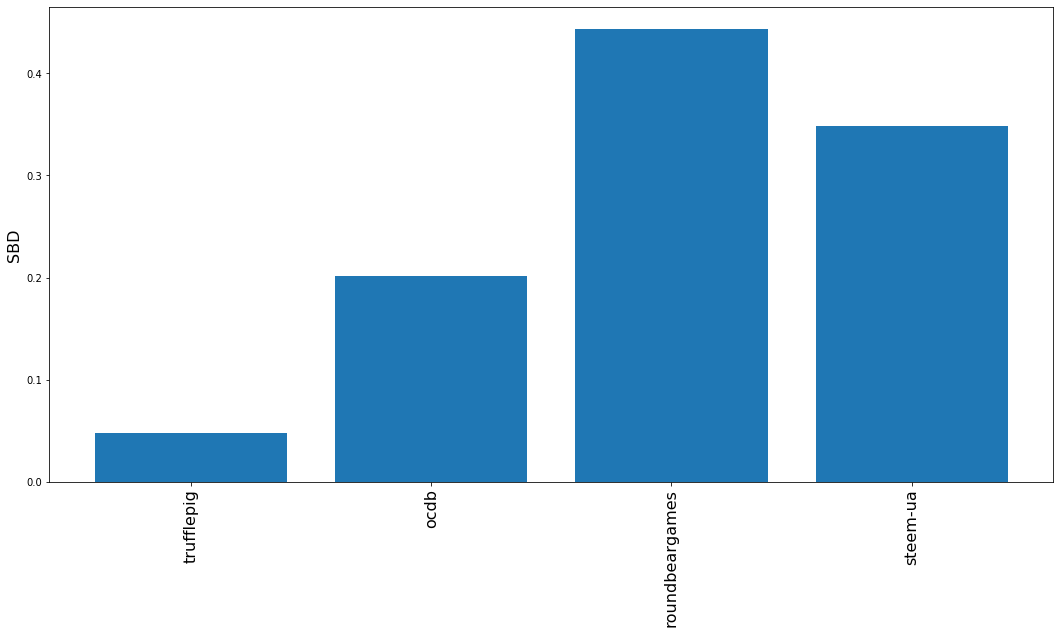

trufflepig    : 0.048
ocdb          : 0.202
roundbeargames: 0.443
steem-ua      : 0.348


In [6]:
senders_amount_steem, senders_amount_sbd, _ = transfers()

steem_ua_rewards = [0.02 * (0.5 * 0.9), 0.015 * (0.75), 0.019 * (0.75), 0.017 * (0.75 * 0.85), 0.02 * (0.75), 0.10 * (0.75), 0.04 * (0.75 * 0.85), 0.25 * (0.75)]
senders_amount_sbd['steem-ua'] = sum(steem_ua_rewards)

senders_amount_steem = [i for i in senders_amount_steem.items() if i[1] > 0.01]
senders_amount_sbd = [i for i in senders_amount_sbd.items() if i[1] > 0.01]

plt.subplots(figsize=(18, 10))
plt.bar(range(len(senders_amount_steem)), [i[1] for i in senders_amount_steem], align='center')
plt.xticks(range(len(senders_amount_steem)), [i[0] for i in senders_amount_steem], rotation='vertical', fontsize=16)
plt.subplots_adjust(bottom=0.15)
plt.ylabel('STEEM', fontsize=16)
plt.subplots_adjust(bottom=0.22)
plt.savefig('transfers_steem.png')
plt.show()

for steem in senders_amount_steem:
    print('{0:<14}: {1:5.3f}'.format(steem[0], steem[1]))

plt.subplots(figsize=(18, 10))
plt.bar(range(len(senders_amount_sbd)), [i[1] for i in senders_amount_sbd], align='center')
plt.xticks(range(len(senders_amount_sbd)), [i[0] for i in senders_amount_sbd], rotation='vertical', fontsize=16)
plt.ylabel('SBD', fontsize=16)
plt.subplots_adjust(bottom=0.22)
plt.savefig('transfers_sbd.png')
plt.show()

for sbd in senders_amount_sbd:
    print('{0:<14}: {1:5.3f}'.format(sbd[0], sbd[1]))

### Rank of Steem on CoinMarketCap over Time:

**IMPORTANT NOTE:** Since I don't want to sign up for a API key, I just scrape CoinMarketCaps's historical snapshots from the website: https://coinmarketcap.com/historical/. In order to not trigger their Clouldflare DDoS protection, I can only do that every 5 seconds. The crawling starts from the launch of STEEM (2016-03-24) and will end at the current date. Writing this on 2019-09-21 means that there are 182 weeks since the launch multiplied by 5 seconds, it will take 910 seconds = 15 minutes until it's done. How long it will take for you depends, on when you launch it, but most likely it will by longer

In [7]:
url = 'https://coinmarketcap.com/historical/'
date = datetime(2016, 3, 27)
ranks = []
dates = []
while datetime.now() > date:
    r = requests.get(url + date.strftime('%Y%m%d/'))
    soup = BeautifulSoup(r.text, 'lxml')
    for i in soup.find_all('tr'): 
        if i.has_attr('id'): 
            if i['id'] == 'id-steem': 
                rank = int(i.find('td').text) 
                ranks.append(rank)
                dates.append(date)
                print(date, rank)
    date += timedelta(days=7)
    time.sleep(5) # needed, so we don't trigger Cloudflare's protection

2016-04-24 00:00:00 22
2016-05-01 00:00:00 15
2016-05-08 00:00:00 18
2016-05-15 00:00:00 10
2016-05-22 00:00:00 10
2016-05-29 00:00:00 10
2016-06-05 00:00:00 12
2016-06-12 00:00:00 11
2016-06-19 00:00:00 13
2016-06-26 00:00:00 16
2016-07-03 00:00:00 15
2016-07-10 00:00:00 8
2016-07-17 00:00:00 3
2016-07-24 00:00:00 3
2016-07-31 00:00:00 3
2016-08-07 00:00:00 3
2016-08-14 00:00:00 5
2016-08-21 00:00:00 4
2016-08-28 00:00:00 7
2016-09-04 00:00:00 7
2016-09-11 00:00:00 7
2016-09-18 00:00:00 8
2016-09-25 00:00:00 7
2016-10-02 00:00:00 8
2016-10-09 00:00:00 9
2016-10-16 00:00:00 9
2016-10-23 00:00:00 10
2016-10-30 00:00:00 12
2016-11-06 00:00:00 9
2016-11-13 00:00:00 12
2016-11-20 00:00:00 12
2016-11-27 00:00:00 9
2016-12-04 00:00:00 8
2016-12-11 00:00:00 8
2016-12-18 00:00:00 9
2016-12-25 00:00:00 10
2017-01-01 00:00:00 10
2017-01-08 00:00:00 10
2017-01-15 00:00:00 11
2017-01-22 00:00:00 10
2017-01-29 00:00:00 11
2017-02-05 00:00:00 12
2017-02-12 00:00:00 12
2017-02-19 00:00:00 13
2017-02-

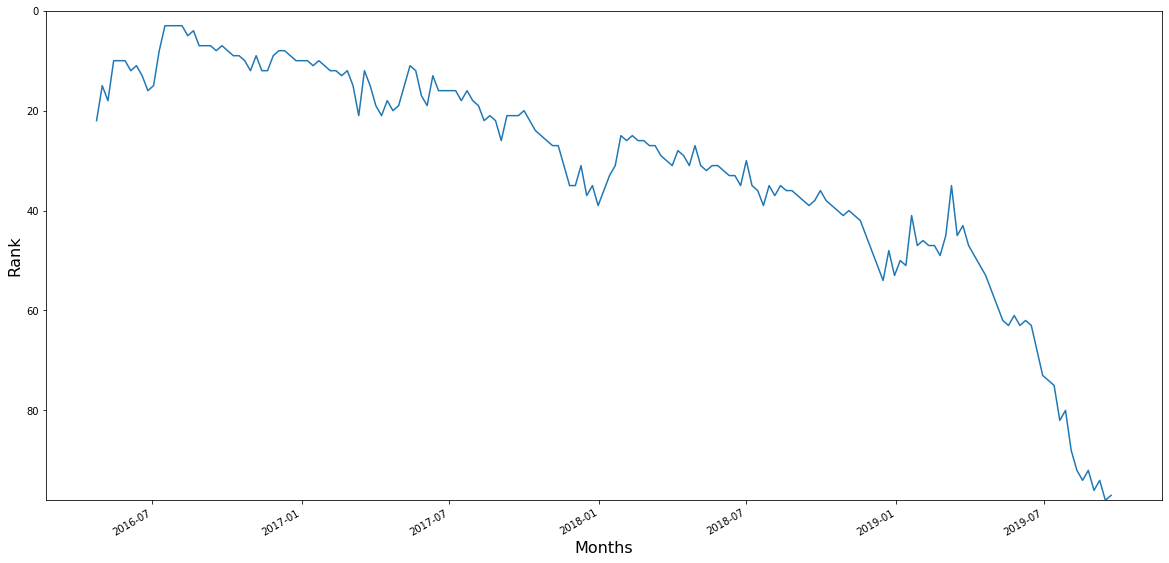

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.autofmt_xdate()
ax.set_xlabel('Months', fontsize=16)
ax.set_ylabel('Rank', fontsize=16)
ax.set_ylim(max(ranks), 0)
ax.plot(dates,ranks)
fig.savefig('steem_cmc.png')